# Learning an embedding function with a `Siamese' Network

Learning objectives: 

* to understand the point of learning an embedding function for one-shot learning

* to see how to construct two (or more) networks with shared weights in Keras

* to train an embedding function using a Siamese network with contrastive divergence, and understand how to assess its performance

* to see how subgraphs constructed in Tensorflow can be combined with a Keras network. 

In [5]:
# as usual we import numpy and matplotlib in the conventional way

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# as usual, you may need to use a different path for importing keras and its functions

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Lambda
from tensorflow.keras.models import Model

In [54]:
from tensorflow.keras.datasets import mnist

In [55]:
# `mnist.load_data` is a utility function provided with Keras that loads the MNIST dataset into convenient 
# variables: oh that data handling were always so simple. 

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [56]:
# These are arrays of small digits - but for this practical we will normalise them (as is good practice)
# to have zero mean and sensible sizes (in the region of 1)

type(x_train)

numpy.ndarray

In [57]:
x_train.shape

(60000, 28, 28)

In [58]:
# let's plot the average value of each pixel in the images

mean_image = np.mean(x_train, axis=0)
mean_image.shape

(28, 28)

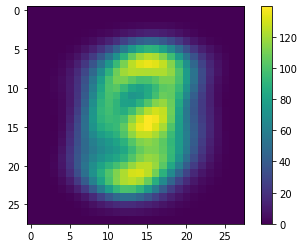

In [59]:
# now plot it - some pixels are going to be more important than others
# in the MNIST dataset, the digits have been centred. The maximum value
# is 255, and the 
plt.imshow( mean_image)
plt.colorbar()


In [60]:
# if you don't know, find out what reshape(-1) does with a numpy array
x_train[0].reshape(-1)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [61]:
# here we are using broadcasting to subtract the mean values for each pixel 
# broadcasting is a short-cut to combining to numpy arrays of different shapes

# check the shape of np.mean( x_train, axis=0)
# it has one less dimension than x_train, so how can we subtract it? 
# What we want to do is subtract the mean image from all the images - and broadcasting
# automatically does this, because the mean of all the images is the same shape as one image; 
# broadcasting automatically subtracts the mean image from each image in the array x_train

# look up numpy broadcasting to see why

# hmmm: I wrote this code hastily, and it breaks a cardinal rule of scripts. Why should I (preferably) not
# redefine x_train and x_test (provided I have enough RAM) ? 
# Why, in this case, does it not matter much? 
x_train = x_train.astype(float) - np.mean(x_train,axis=0)
x_test = x_test.astype(float) - np.mean(x_test,axis=0)

(array([272.,  58.,  51.,  36.,  39.,  27.,  30.,  36.,  45., 190.]),
 array([  0.        ,  11.38130593,  22.76261187,  34.1439178 ,
         45.52522373,  56.90652966,  68.2878356 ,  79.66914153,
         91.05044746, 102.43175339, 113.81305933]),
 <a list of 10 Patch objects>)

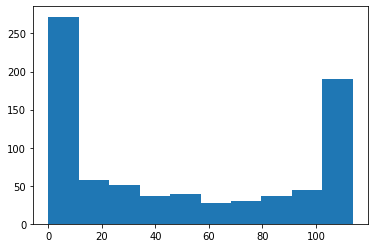

In [62]:
# as always, look at the values in the data. 
# what are the standard deviations of pixels, over the dataset? 

# x_train.reshape((-1,784)) reshapes each image into a 784 element row vector, so we have a 60000x784 
# matrix, with one column corresponding to each pixel

# next, compute the std of each

plt.hist( np.std( x_train.reshape((-1,784)), axis=0))

(array([ 2227990.,  4185166.,  5607927., 28283466.,   762712.,   794247.,
         1677842.,  2265744.,   884265.,   350641.]),
 array([-2.1103304 , -1.51371851, -0.91710663, -0.32049474,  0.27611715,
         0.87272903,  1.46934092,  2.0659528 ,  2.66256469,  3.25917658,
         3.85578846]),
 <a list of 10 Patch objects>)

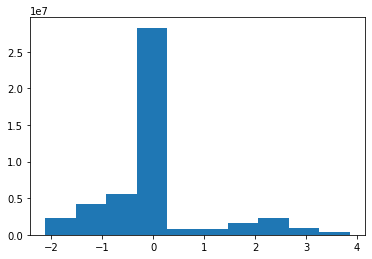

In [63]:
# Normalising the values is quite tricky: we want to get the values to have a standard deviation of roughly
# one - but this may not be possible or reasonable, because some pixels are zero in nearly all the images. 
# We don't want to make these pixel values enormous for the very few images in which they appear

# So a reasonable normalisation which will make all pixel values have small, reasonable values is to 
# divide all pixel values by the standard deviation of _all_ pixel values.

std_train = np.std( x_train.reshape(-1) )

x_train = x_train / std_train
x_test = x_test / std_train

plt.hist( x_train.reshape(-1))

# Looks ok - all pixel avlues are between -2 and +4
# this makes learning faster in the initial stages; if the first layer has saturating neurons
# ( such as neurons with activation tanh) then large input values can cause all the neurons to 
# saturate, forcing all gradients small, which slows down learning in the initial stages. 

In [64]:
x_train.shape

(60000, 28, 28)

# Constructing the Training and Test Data for a Siamese Network

One difference between learning an embedding and classification learning is that to learn an embedding, 
we want to train according to the distances betweeen pairs of items. 

Each training example consists of ***two*** digit images, and the label `y` will be 0 if the images are similar (in this case, if they are of the same digit), and 1 if they are different. 

In learning an embedding, we seek to adjust the embedding function to make the embedding vectors of similar pairs be close together, and the embedding vectors of different pairs to be a distance of at least one apart. 

First, we need to construct a training set of pairs of digit-images, together with the appropriate `y` values. 

In [65]:
# Now construct a data set 

# probability of success is 1/10, so to get equal probability of match and non-match
# we can with accept a different pair with probability 1/9 

# It looks as if we need a list of 2 isomorphic arrays of digits, and an array of labels

# Each label is 0 if the two images are of the same digit, and 1 if they are of different digits

from random import randint  # a useful function

def construct_pairs_dataset( n_data, mnist_images, mnist_labels):
    n_mnist = mnist_images.shape[0]
    assert mnist_labels.shape[0] == mnist_images.shape[0]
    x_shape = (n_data, 28, 28, 1)
    x_train1 = np.zeros(x_shape)
    x_train2 = np.zeros(x_shape)
    y_train = np.zeros([n_data,1])
    # randomly select a pair of indices in the training data
    
    for i in range(0,n_data):
        while True: # this while True .... break idiom is Pythonic for do...while .  Yuk, I agree. 
            while True:
                x1 = randint(0,n_data-1)
                x2 = randint(0,n_data-1)
                if x1 != x2:  # we can get a division by zero bug later if two images are exactly the same
                    break
            # see if they are same or different, randomly accept
            if mnist_labels[x1] == mnist_labels[x2]:
                y_train[i,0] = 0
                break
            else:
                if np.random.random() < 0.111111111:
                    y_train[i,0] = 1
                    break
        x_train1[i,:,:,0] = mnist_images[x1]
        x_train2[i,:,:,0] = mnist_images[x2]
    
    return ( [x_train1, x_train2], y_train )

In [66]:
pairs_train, py_train = construct_pairs_dataset( 2000, x_train, y_train)
pairs_test, py_test = construct_pairs_dataset( 2000, x_test, y_test)

In [67]:
#  Now let's just check that our pairs data really is what we think it is

pairs0 = pairs_train[0]
pairs1 = pairs_train[1]


array([0.])

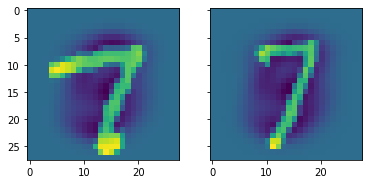

In [68]:
# we define idx to be any valid index for the training data, and then we plot both images, and also print the 
# corresponding `y` value. We can then see if images of the same digit do have y==0, and of different digits
# do have y==1. 

idx = 11
fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].imshow( pairs0[idx,:,:,0]) 
ax[1].imshow( pairs1[idx,:,:,0])
py_train[idx]

# Constructing the Siamese network

We construct the embedding network and the Siamese network separately.  The embedding network is used as a component in the Siamese network. 

But first we need to define Tensorflow functions for Euclidean distances (this will compute the distances between embedding vectors that we wish to minimise), and for the contrastive divergence


In [69]:
# this imports Tensorflow (this is a conventional import statement: someone else
# using the code might be using a different backend for Keras)

import tensorflow.keras.backend as K

In [70]:
# this function deserves careful scrutiny

# It looks as if it is operating on arrays of numbers: actually it is defining a Tensorflow 
# program ( a computational graph) that computes a new tensor, containing the euclidean distances
# between corresponding rows in the two 

def euclidean_distances_of_rows(inputs):
    """
    inputs is a list of two Tensorflow nodes, each being a tensor (array) with at least two dimensions;
    this then defines a program to compute the 
    """
    assert len(inputs) == 2, \
        'List/tuple of length 2 needed: argument length is %d ' % len(inputs)
    u, v = inputs
    return K.sqrt( K.sum( K.square(u - v), axis=1, keepdims=True) )

In [71]:
# this function defines a Tensorflow graph that computes contrastive loss
# it looks deceptively like a Python function, but the inputs will be Tensors
# In this case, the inputs will be a Tensor of true class labels for the current batch, 
# and a Tensor of the computed Euclidean distances for the current batch

# We will use this contrastive loss instead of the log-loss we have generally been using so far. 

def contrastive_loss(y, d):
    return (1-y) * K.square(d) + y * K.square( K.maximum(1 - d, 0)) 

In [72]:
# 
digit_input = Input(shape=(28, 28, 1))
x = Flatten()(digit_input)
x = Dense(30,activation='relu')(x)
#x = Conv2D(20, (3, 3), activation='relu')(x)
#x = Conv2D(20, (3, 3), activation='relu')(x)
#x = MaxPooling2D((2, 2))(x)
#x = Conv2D(40,(3,3),activation='relu')(x)
#x = MaxPooling2D((2, 2))(x)
out =  Dense(30,activation='tanh')(x)

embedding_model_1 = Model(digit_input, out)

In [73]:
embedding_model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
Total params: 24,480
Trainable params: 24,480
Non-trainable params: 0
_________________________________________________________________


In [74]:
# First, define the vision modules
digit_input = Input(shape=(28, 28, 1))
#x = Flatten()(digit_input)
#x = Dense(30,activation='relu')(x)
x = Conv2D(20, (3, 3), activation='relu')(digit_input)
x = Conv2D(20, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(40,(3,3),activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
out =  Dense(30,activation='tanh')(x)

embedding_model_2 = Model(digit_input, out)

In [75]:
embedding_model_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 20)        200       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 20)        3620      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 40)        7240      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1000)              0   

In [76]:
# This defines the Siamese network
# note that the embedding model is used twice, but it only has one set of weights
# compare the number of trainable weights in the summary of the Siamese model and the embedding model
# Only one embedding model is being trained. 

digit_a = Input(shape=(28, 28, 1))
digit_b = Input(shape=(28, 28, 1))

# The embedding model will be shared, weights and all
out_a = embedding_model_1(digit_a)
out_b = embedding_model_1(digit_b)

s1 = Lambda(euclidean_distances_of_rows)([out_a, out_b])

embedding_distance_model = Model([digit_a, digit_b], s1)

In [77]:
embedding_distance_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 30)           24480       input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_3[1][0]              

In [78]:
embedding_distance_model.compile(loss=contrastive_loss,
              optimizer='rmsprop')
              #metrics=['accuracy'])

Before training the Siamese network, let us look carefully at what is being computed

The digit embeddings are computed by the embedding network

In [79]:
# we can use the embedding model's initialised weights to predict the embedding vectors
# for each digit in the untrained model. 

# look at the shapes of these
# what are they? 

emb0 = embedding_model_1.predict( pairs_train[0])
emb1 = embedding_model_1.predict( pairs_train[1])

In [80]:
# we can compute in Python distances between the embedding vectors of each pair of digit-images

distances_from_emb01 = np.sqrt( np.sum( np.square( emb0 - emb1 ), axis = 1))
distances_from_emb01

array([3.3951147, 4.0174255, 3.8554375, ..., 4.5555506, 3.4912775,
       3.2809885], dtype=float32)

In [81]:
# the output (not the losses) of the Siamese network should be the same numbers - the distances between 
# pairs of embedding vectors

distances = embedding_distance_model.predict(pairs_train)
distances

array([[3.3951147],
       [4.0174255],
       [3.8554373],
       ...,
       [4.5555506],
       [3.491277 ],
       [3.2809885]], dtype=float32)

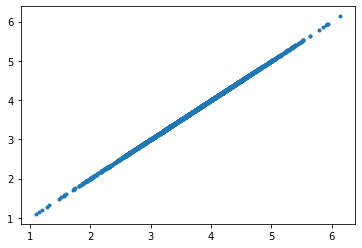

In [82]:
# let's check that the distances computed by the Siamese network, and the distances we computed 
# in Python, are really the same, by plotting them against each other

# note that I reshape the network output to make it a one-dimensional vector
plt.plot( distances.reshape([-1]), distances_from_emb01, '.')

# this graph should be a straight line corresponding to the identity function ! 

In [83]:
# now calculate what the loss should be

# this is a function that computes the contrastive loss in Python (as opposed to Tensorflow)
def python_contrastive_loss( y, d):
    return  (( (1-y) * np.square(d)) + y * np.square( np.maximum(1-d,0)))

# Now use this function to compute the mean contrastive loss over the training set, 

In [84]:
pcl = python_contrastive_loss( py_train, distances)

In [85]:
np.mean(pcl)

6.558873298704624

In [86]:
# we can evaluate the loss of the untrained Siamese network on the training data:
# The loss should be the same as the one we computed in Python, above.

evals = embedding_distance_model.evaluate( pairs_train, py_train)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [87]:
evals

6.558873210906983

In [88]:
# now fit the Siamese model
# I have put episodes = 5, but you may need more episodes to complete the training

history = embedding_distance_model.fit(pairs_train, py_train, batch_size=100, 
                                   epochs=5, shuffle=True, validation_data=(pairs_test,py_test))


Train on 2000 samples, validate on 2000 samples
Epoch 1/5
2000/2000 [==============================] - 1s 355us/sample - loss: 4.1400 - val_loss: 3.1632
Epoch 2/5
2000/2000 [==============================] - 0s 45us/sample - loss: 2.0181 - val_loss: 2.2298
Epoch 3/5
2000/2000 [==============================] - 0s 42us/sample - loss: 1.2229 - val_loss: 1.5910
Epoch 4/5
2000/2000 [==============================] - 0s 45us/sample - loss: 0.7371 - val_loss: 1.0833
Epoch 5/5
2000/2000 [==============================] - 0s 55us/sample - loss: 0.4264 - val_loss: 0.7292


In [89]:
# Now let's plot the distances between same-digit pairs and different-digit pairs after training, for the 
# training and test sets

preds_after_training = embedding_distance_model.predict( pairs_train).reshape(-1)
test_preds_after_training = embedding_distance_model.predict( pairs_test).reshape(-1)

In [90]:
np.mean( preds_after_training[ py_train[:,0] == 0 ]), np.mean( preds_after_training[ py_train[:,0] == 1 ])

(0.6937268, 1.3645235)

In [91]:
np.mean( test_preds_after_training[ py_test[:,0] == 0 ]), np.mean( test_preds_after_training[ py_test[:,0] == 1 ])

(1.1114802, 1.452151)

(array([ 35., 112., 157., 221., 159., 147.,  74.,  51.,  25.,  15.]),
 array([0.49536943, 0.7071753 , 0.9189812 , 1.130787  , 1.342593  ,
        1.5543988 , 1.7662046 , 1.9780105 , 2.1898165 , 2.4016223 ,
        2.613428  ], dtype=float32),
 <a list of 10 Patch objects>)

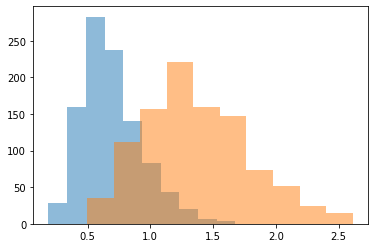

In [92]:
plt.hist( preds_after_training[ py_train[:,0] == 0 ], alpha=0.5, label='same')
plt.hist( preds_after_training[ py_train[:,0] == 1 ], alpha=0.5, label='different')

# this plot should show the training set has been clearly separated - different 
# digits are further apart than same-digits

(array([ 14.,  55., 141., 208., 248., 156., 105.,  53.,   8.,   3.]),
 array([0.33495006, 0.5901545 , 0.845359  , 1.1005635 , 1.355768  ,
        1.6109724 , 1.866177  , 2.1213815 , 2.376586  , 2.6317904 ,
        2.8869948 ], dtype=float32),
 <a list of 10 Patch objects>)

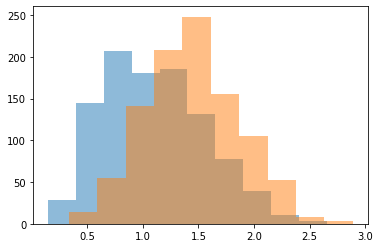

In [93]:
plt.hist( test_preds_after_training[ py_test[:,0] == 0 ], alpha=0.5, label='same')
plt.hist( test_preds_after_training[ py_test[:,0] == 1 ], alpha=0.5, label='different')

# this plot may show considerable overlap still present in the test set, if there has been 
# overfitting. 

# some embedding networks will be much better than others! 

In [94]:
# Now construct a data set 

# probability of success is 1/10, so to get equal probability of match and non-match
# we can with accept a different pair with probability 1/9 

# It looks as if we need a list of 2 isomorphic arrays of digits, and an array of labels

# Each label is 0 if the two images are of the same digit, and 1 if they are of different digits

from random import randint  # a useful function

def construct_pairs_dataset( n_data, mnist_images, mnist_labels):
    n_mnist = mnist_images.shape[0]
    assert mnist_labels.shape[0] == mnist_images.shape[0]
    x_shape = (n_data, 28, 28, 1)
    x_train1 = np.zeros(x_shape)
    x_train2 = np.zeros(x_shape)
    y_train = np.zeros([n_data,1])
    # randomly select a pair of indices in the training data
    
    for i in range(0,n_data):
        while True: # this while True .... break idiom is Pythonic for do...while .  Yuk, I agree. 
            while True:
                x1 = randint(0,n_data-1)
                x2 = randint(0,n_data-1)
                if x1 != x2:
                    break
            # see if they are same or different, randomly accept
            if mnist_labels[x1] == mnist_labels[x2]:
                y_train[i,0] = 0
                break
            else:
                if np.random.random() < 0.111111111:
                    y_train[i,0] = 1
                    break
        x_train1[i,:,:,0] = mnist_images[x1]
        x_train2[i,:,:,0] = mnist_images[x2]
    
    return ( [x_train1, x_train2], y_train )

In [95]:
pairs_train, py_train = construct_pairs_dataset( 2000, x_train, y_train)
pairs_test, py_test = construct_pairs_dataset( 2000, x_test, y_test)

In [96]:
pairs0 = pairs_train[0]
pairs1 = pairs_train[1]


array([0.])

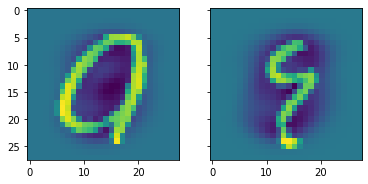

In [97]:
idx = 11
fig,ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].imshow( pairs0[idx,:,:,0]) 
ax[1].imshow( pairs1[idx,:,:,0])
py_train[idx]